# COVID-19 Cases Prediction

Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)

In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import csv
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [2]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()
    
    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

def get_model_test_dev_score(test_set, dv_set, model, device):
    
    def get_score(data_set):
        preds, targets = [], []
        for x, y in data_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()
        return preds, targets
    model.eval()
    preds_test, targets_test = get_score(test_set)
    preds_dev, targets_dev = get_score(dv_set)
    
    print(f"MSE of test set: {mean_squared_error(targets_test, preds_test)}")
    print(f"MSE of dev set: {mean_squared_error(targets_dev, preds_dev)}")
    return mean_squared_error(targets_test, preds_test), mean_squared_error(targets_dev, preds_dev)

model_loss_records = {}

def store_model_test_dev_scores_into_dict(model_name, train_score, dev_score):
    if model_name not in model_loss_records:
        model_loss_records[model_name] = {'train': '', 'dev': ''}
    model_loss_records[model_name]['train'] = train_score
    model_loss_records[model_name]['dev'] = dev_score
    return model_loss_records

## 1. Working with data

In [3]:
tr_path = "dataset/covid.train.csv"
tt_path = "dataset/covid.test.shuffle.csv"

In [4]:
df = pd.read_csv(tr_path)
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]
df.head()
print([i for i in X.columns.values])

['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE', 'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX', 'UT', 'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli', 'nohh_cmnty_cli', 'wearing_mask', 'travel_outside_state', 'work_outside_home', 'shop', 'restaurant', 'spent_time', 'large_event', 'public_transit', 'anxious', 'depressed', 'felt_isolated', 'worried_become_ill', 'worried_finances', 'tested_positive', 'cli.1', 'ili.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'wearing_mask.1', 'travel_outside_state.1', 'work_outside_home.1', 'shop.1', 'restaurant.1', 'spent_time.1', 'large_event.1', 'public_transit.1', 'anxious.1', 'depressed.1', 'felt_isolated.1', 'worried_become_ill.1', 'worried_finances.1', 'tested_positive.1', 'cli.2', 'ili.2', 'hh_cmnty_cli.2', 'nohh_cmnty_cli.2', 'wearing_mask.2', 'travel_outside_state.2', 'work_outside_home.2', 'shop.2', 'restaurant.2', 'spent_time.2'

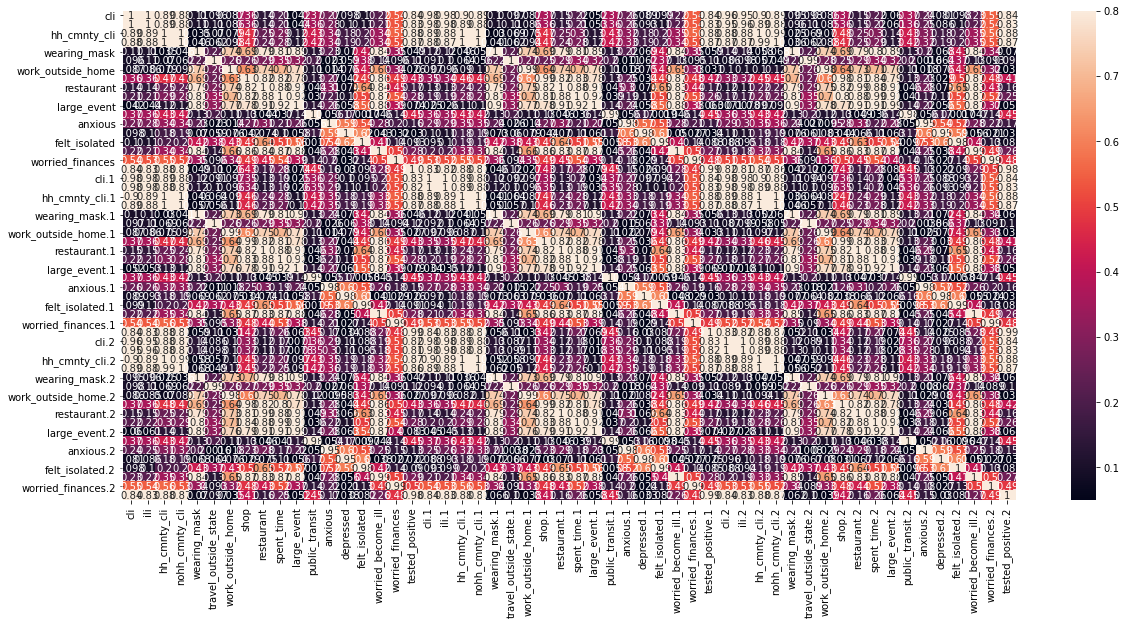

In [5]:
#num_cols = data_clean.describe().columns
corr_matrix = df.iloc[:,41:].astype(float).corr()
corr_matrix = abs(corr_matrix)

f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr_matrix, vmax=0.8, vmin=0.05, annot=True)
plt.show()

In [6]:
corr_matrix

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
cli,1.000000,0.995735,0.893416,0.882322,0.107406,0.095964,0.087305,0.364165,0.143318,0.209020,...,0.151291,0.222834,0.060308,0.374071,0.237135,0.081456,0.098345,0.228750,0.550564,0.838504
ili,0.995735,1.000000,0.889729,0.878280,0.109015,0.106934,0.086355,0.357443,0.142082,0.207210,...,0.150141,0.220942,0.061298,0.363873,0.245228,0.086229,0.104250,0.222909,0.544776,0.830527
hh_cmnty_cli,0.893416,0.889729,1.000000,0.997225,0.035441,0.069595,0.079219,0.472746,0.247043,0.293775,...,0.253615,0.300062,0.136937,0.433276,0.307581,0.181497,0.203577,0.350255,0.561942,0.879724
nohh_cmnty_cli,0.882322,0.878280,0.997225,1.000000,0.046063,0.061914,0.097756,0.465374,0.238106,0.280916,...,0.245265,0.287482,0.129474,0.424996,0.317836,0.188467,0.203599,0.345448,0.534711,0.869938
wearing_mask,0.107406,0.109015,0.035441,0.046063,1.000000,0.220808,0.735649,0.691597,0.788714,0.807623,...,0.785281,0.802659,0.889021,0.133487,0.204031,0.067720,0.427533,0.840528,0.340101,0.069531
travel_outside_state,0.095964,0.106934,0.069595,0.061914,0.220808,1.000000,0.264107,0.256911,0.288473,0.349829,...,0.288098,0.336937,0.319736,0.203611,0.001592,0.064425,0.370776,0.131961,0.093096,0.097303
work_outside_home,0.087305,0.086355,0.079219,0.097756,0.735649,0.264107,1.000000,0.631958,0.743673,0.698047,...,0.730349,0.705533,0.758575,0.110176,0.018259,0.075562,0.430307,0.652231,0.317717,0.034865
shop,0.364165,0.357443,0.472746,0.465374,0.691597,0.256911,0.631958,1.000000,0.820916,0.819035,...,0.811055,0.838358,0.787237,0.130046,0.228007,0.029168,0.496368,0.866789,0.475304,0.410430
restaurant,0.143318,0.142082,0.247043,0.238106,0.788714,0.288473,0.743673,0.820916,1.000000,0.878576,...,0.993358,0.876107,0.909089,0.046081,0.278715,0.074727,0.648631,0.832131,0.430842,0.157945
spent_time,0.209020,0.207210,0.293775,0.280916,0.807623,0.349829,0.698047,0.819035,0.878576,1.000000,...,0.875365,0.986713,0.912682,0.040623,0.169965,0.105281,0.517139,0.867460,0.522985,0.252125


In [7]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode
        
        # Read csv into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        # Determine what features to export
        if not target_only:
            #num_rows, num_cols = data.shape
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
                # ANS: to define the indices of columns for training/testing
            feats = list(range(40)) + [40, 42, 43, 59, 60, 61, 63, 75, 77, 78, 81]
            # good but no std [40, 41, 43, 51, 52, 53, 58, 59, 60, 63, 69, 70, 71, 75, 77, 78, 81, 87]
            #[40, 41, 42, 43, 47, 51, 56, 57, 58, 59, 60, 61, 65, 69, 74, 75, 76, 77, 78, 79, 83, 87, 92]
            #[40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79]
            pass
        
        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            
            # Splitting training data into train & dev sets
            x_train, x_test, y_train, y_test = train_test_split(
                data, 
                target, 
                random_state=42, 
                test_size=0.1)
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])
            
        # Normalize features 
        
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)
        
        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))
    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)
        

In [8]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

## 2. Create model: Deep Neural Network

In [9]:
class NeuralNet(nn.Module):
    ''' NN with 1 layer '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        
        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            nn.ReLU(),
            torch.nn.Linear(64, 1)
        )
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)
    
    def get_model_name(self):
        return 'model_baseline'

## 3. Create functions of Training/Tesing a model 

In [10]:
def train(tr_set, dv_set, model, config, device, silent=False):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            if not silent:
                print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [11]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [12]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

## 4. Train baseline model
- number of features: 93 (all)
- number of hiden layers: 1

In [13]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model_baseline.pth'  # your model will be saved here
}

### 4.1 Load data

In [14]:
target_only = False
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


### 4.2 Load model

In [15]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

### 4.3 Start to train

In [16]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 74.9742)
Saving model (epoch =    2, loss = 50.5313)
Saving model (epoch =    3, loss = 29.1148)
Saving model (epoch =    4, loss = 15.8134)
Saving model (epoch =    5, loss = 9.5430)
Saving model (epoch =    6, loss = 6.8086)
Saving model (epoch =    7, loss = 5.3892)
Saving model (epoch =    8, loss = 4.5267)
Saving model (epoch =    9, loss = 3.9454)
Saving model (epoch =   10, loss = 3.5560)
Saving model (epoch =   11, loss = 3.2303)
Saving model (epoch =   12, loss = 2.9920)
Saving model (epoch =   13, loss = 2.7737)
Saving model (epoch =   14, loss = 2.6181)
Saving model (epoch =   15, loss = 2.3987)
Saving model (epoch =   16, loss = 2.2712)
Saving model (epoch =   17, loss = 2.1349)
Saving model (epoch =   18, loss = 2.0210)
Saving model (epoch =   19, loss = 1.8848)
Saving model (epoch =   20, loss = 1.7999)
Saving model (epoch =   21, loss = 1.7510)
Saving model (epoch =   22, loss = 1.6787)
Saving model (epoch =   23, loss = 1.6450)
Saving 

### 4.4 Evaluation

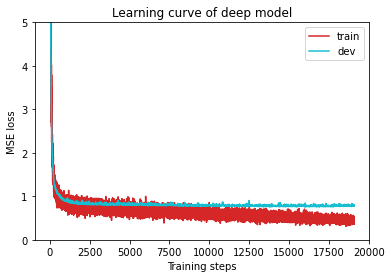

In [17]:
plot_learning_curve(model_loss_record, title='deep model')

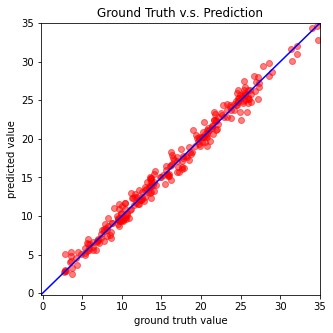

MSE of test set: 0.4693859815597534
MSE of dev set: 0.7531372308731079


In [18]:
del model

model = NeuralNet(tr_set.dataset.dim).to(device)
model_name = model.get_model_name()
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

tr_score, dv_score = get_model_test_dev_score(tr_set, dv_set, model, device)
loss_score_records = store_model_test_dev_scores_into_dict(model_name, tr_score, dv_score)

### 4.5 Summary: baseline model is overfitting
Next steps:
1. shrink the number of features
2. L2 regulurzaion

## 5. Soultion to overfitting: reduce the number of features

### 5.1 Feature selection by using RFECV

In [19]:
from sklearn.feature_selection import RFECV
from sklearn import linear_model

df = pd.read_csv(tr_path)
X = df.iloc[:,41:-1]
y = df.iloc[:,-1]
# Normalize features 

X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

ols = linear_model.LinearRegression()
rfecv = RFECV(estimator=ols, step=1, scoring='neg_mean_squared_error')
rfecv.fit(X, y)
rfecv.transform(X)

# get the index of importanct features
lst = list(rfecv.support_)
inds = []
for i in range(len(lst)):
    if lst[i]:
        inds.append(i+40)
inds

[40, 42, 43, 59, 60, 61, 63, 75, 77, 78, 81]

### 5.2 Start to train model

In [20]:
target_only = True
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 51)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 51)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 51)


In [21]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

In [22]:
model_name = 'model_L1U64'
config['save_path'] = f'models/{model_name}.pth'
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 200.0875)
Saving model (epoch =    2, loss = 85.5479)
Saving model (epoch =    3, loss = 43.4086)
Saving model (epoch =    4, loss = 13.0780)
Saving model (epoch =    5, loss = 4.2492)
Saving model (epoch =    6, loss = 2.1947)
Saving model (epoch =    7, loss = 1.5974)
Saving model (epoch =    8, loss = 1.4695)
Saving model (epoch =    9, loss = 1.2419)
Saving model (epoch =   10, loss = 1.2059)
Saving model (epoch =   11, loss = 1.0715)
Saving model (epoch =   12, loss = 1.0415)
Saving model (epoch =   13, loss = 1.0167)
Saving model (epoch =   14, loss = 0.9925)
Saving model (epoch =   15, loss = 0.9801)
Saving model (epoch =   16, loss = 0.9647)
Saving model (epoch =   17, loss = 0.9628)
Saving model (epoch =   18, loss = 0.9540)
Saving model (epoch =   19, loss = 0.9362)
Saving model (epoch =   20, loss = 0.9351)
Saving model (epoch =   21, loss = 0.9334)
Saving model (epoch =   22, loss = 0.9160)
Saving model (epoch =   24, loss = 0.9107)
Saving

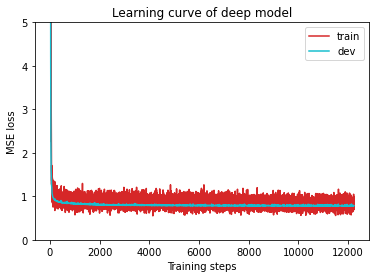

In [23]:
plot_learning_curve(model_loss_record, title='deep model')

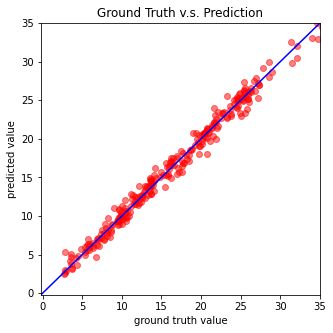

MSE of test set: 0.8275723457336426
MSE of dev set: 0.774623692035675


In [24]:
del model

model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

tr_score, dv_score = get_model_test_dev_score(tr_set, dv_set, model, device)
loss_score_records = store_model_test_dev_scores_into_dict(model_name, tr_score, dv_score)

### 5.2 Summary
got improvement!

## 6. Design model architecture
1. the number of hidden layers
2. the number of hidden layer units

In [25]:
def train_multi_models_at_once(model_lst, r_set, dv_set, model, config, device):
    print(f'{len(model_lst)} models are detected.')
    print('------')
    cnt = 1
    for model in model_lst:
        model_name = model.get_model_name()
        
        print(f'{cnt}.1 Start to train {model_name}')
        config['save_path'] = f'models/{model_name}.pth'

        model_loss, model_loss_record = train(tr_set, dv_set, model, config, device, silent=True)
        plot_learning_curve(model_loss_record, title='deep model')
        
        print(f'{cnt}.2 Finish training {model_name}')
          
        print(f'{cnt}.3 Evaluate the final model of {model_name}')
        model = model.to(device)
        ckpt = torch.load(f'models/{model_name}.pth', map_location='cpu')  # Load your best model
        model.load_state_dict(ckpt)
        # plot_pred(dv_set, model, device)  # Show prediction on the validation set
        tr_score, dv_score = get_model_test_dev_score(tr_set, dv_set, model, device)
        loss_score_records = store_model_test_dev_scores_into_dict(model_name, tr_score, dv_score)
        cnt += 1
        print()



In [26]:
class NeuralNetL1U48(nn.Module):
    ''' NN with 2 layers '''
    def __init__(self, input_dim):
        super(NeuralNetL1U48, self).__init__()
        
        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            torch.nn.Linear(input_dim, 48),
            nn.ReLU(),
            torch.nn.Linear(48, 1)
        )
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)
    
    def get_model_name(self):
        return 'model_L1U48'

class NeuralNetL1U32(nn.Module):
    ''' NN with 3 layers '''
    def __init__(self, input_dim):
        super(NeuralNetL1U32, self).__init__()
        
        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            torch.nn.Linear(input_dim, 32),
            nn.ReLU(),
            torch.nn.Linear(32, 1)
        )
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)
    
    def get_model_name(self):
        return 'model_L1U32'
    
class NeuralNetL2U64(nn.Module):
    ''' NN with 4 layers '''
    def __init__(self, input_dim):
        super(NeuralNetL2U64, self).__init__()
        
        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            nn.ReLU(),
            torch.nn.Linear(64, 32),
            nn.ReLU(),
            torch.nn.Linear(32, 1)
        )
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)
    
    def get_model_name(self):
        return 'model_L2U64'

class NeuralNetL2U48(nn.Module):
    ''' NN with 5 layers '''
    def __init__(self, input_dim):
        super(NeuralNetL2U48, self).__init__()
        
        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            torch.nn.Linear(input_dim, 48),
            nn.ReLU(),
            torch.nn.Linear(48, 24),
            nn.ReLU(),
            torch.nn.Linear(24, 1)
        )
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)
    
    def get_model_name(self):
        return 'model_L2U48'

class NeuralNetL2U32(nn.Module):
    ''' NN with 5 layers '''
    def __init__(self, input_dim):
        super(NeuralNetL2U32, self).__init__()
        
        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            torch.nn.Linear(input_dim, 32),
            nn.ReLU(),
            torch.nn.Linear(32, 16),
            nn.ReLU(),
            torch.nn.Linear(16, 1)
        )
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)
    
    def get_model_name(self):
        return 'model_L2U32'
    
class NeuralNetL3U64(nn.Module):
    ''' NN with 4 layers '''
    def __init__(self, input_dim):
        super(NeuralNetL3U64, self).__init__()
        
        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            nn.ReLU(),
            torch.nn.Linear(64, 32),
            nn.ReLU(),
            torch.nn.Linear(32, 16),
            nn.ReLU(),
            torch.nn.Linear(16, 1)
        )
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)
    
    def get_model_name(self):
        return 'model_L3U64'

class NeuralNetL3U48(nn.Module):
    ''' NN with 5 layers '''
    def __init__(self, input_dim):
        super(NeuralNetL3U48, self).__init__()
        
        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            torch.nn.Linear(input_dim, 48),
            nn.ReLU(),
            torch.nn.Linear(48, 24),
            nn.ReLU(),
            torch.nn.Linear(24, 12),
            nn.ReLU(),
            torch.nn.Linear(12, 1)
        )
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)
    
    def get_model_name(self):
        return 'model_L3U48'

class NeuralNetL3U32(nn.Module):
    ''' NN with 5 layers '''
    def __init__(self, input_dim):
        super(NeuralNetL3U32, self).__init__()
        
        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            torch.nn.Linear(input_dim, 32),
            nn.ReLU(),
            torch.nn.Linear(32, 16),
            nn.ReLU(),
            torch.nn.Linear(16, 8),
            nn.ReLU(),
            torch.nn.Linear(8, 1)
        )
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)
    
    def get_model_name(self):
        return 'model_L3U32'

In [27]:
target_only = True
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 51)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 51)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 51)


In [28]:
model_L1U48 = NeuralNetL1U48(tr_set.dataset.dim).to(device)  # Construct model and move to device
model_L1U32 = NeuralNetL1U32(tr_set.dataset.dim).to(device)
model_L2U64 = NeuralNetL2U64(tr_set.dataset.dim).to(device)
model_L2U48 = NeuralNetL2U48(tr_set.dataset.dim).to(device)
model_L2U32 = NeuralNetL2U32(tr_set.dataset.dim).to(device)
model_L3U64 = NeuralNetL3U64(tr_set.dataset.dim).to(device)
model_L3U48 = NeuralNetL3U48(tr_set.dataset.dim).to(device)
model_L3U32 = NeuralNetL3U32(tr_set.dataset.dim).to(device)

8 models are detected.
------
1.1 Start to train model_L1U48
Finished training after 1026 epochs


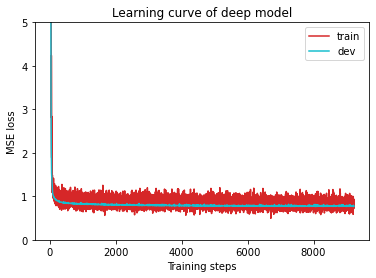

1.2 Finish training model_L1U48
1.3 Evaluate the final model of model_L1U48
MSE of test set: 0.8339200019836426
MSE of dev set: 0.7645686268806458

2.1 Start to train model_L1U32
Finished training after 1803 epochs


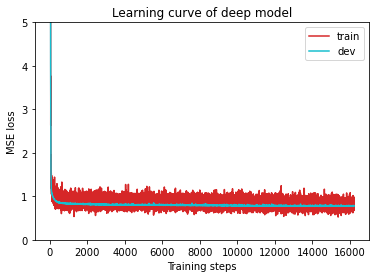

2.2 Finish training model_L1U32
2.3 Evaluate the final model of model_L1U32
MSE of test set: 0.8178955912590027
MSE of dev set: 0.7669902443885803

3.1 Start to train model_L2U64
Finished training after 957 epochs


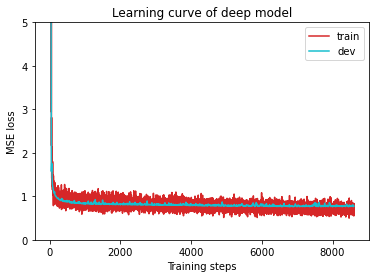

3.2 Finish training model_L2U64
3.3 Evaluate the final model of model_L2U64
MSE of test set: 0.7284401059150696
MSE of dev set: 0.7595638632774353

4.1 Start to train model_L2U48
Finished training after 723 epochs


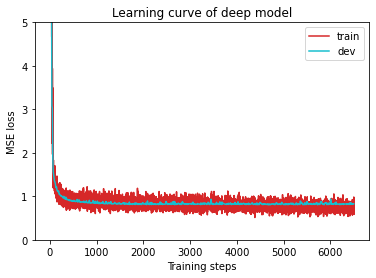

4.2 Finish training model_L2U48
4.3 Evaluate the final model of model_L2U48
MSE of test set: 0.7757406830787659
MSE of dev set: 0.8061687350273132

5.1 Start to train model_L2U32
Finished training after 1667 epochs


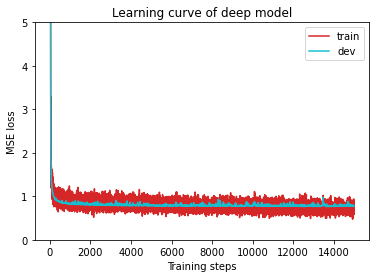

5.2 Finish training model_L2U32
5.3 Evaluate the final model of model_L2U32
MSE of test set: 0.7227988839149475
MSE of dev set: 0.7632459998130798

6.1 Start to train model_L3U64
Finished training after 898 epochs


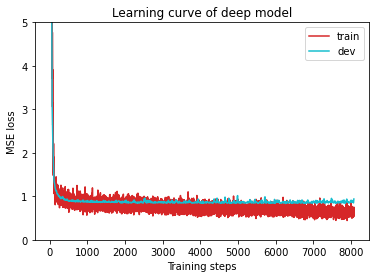

6.2 Finish training model_L3U64
6.3 Evaluate the final model of model_L3U64
MSE of test set: 0.6599044799804688
MSE of dev set: 0.8344618082046509

7.1 Start to train model_L3U48
Finished training after 456 epochs


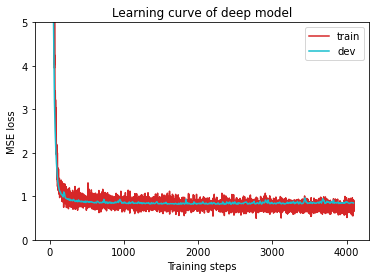

7.2 Finish training model_L3U48
7.3 Evaluate the final model of model_L3U48
MSE of test set: 0.7861095070838928
MSE of dev set: 0.8176154494285583

8.1 Start to train model_L3U32
Finished training after 498 epochs


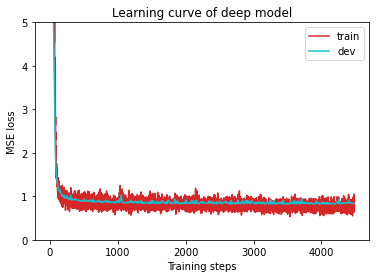

8.2 Finish training model_L3U32
8.3 Evaluate the final model of model_L3U32
MSE of test set: 0.7936832904815674
MSE of dev set: 0.8177053332328796



In [29]:
model_lst = [model_L1U48, model_L1U32, model_L2U64, model_L2U48, model_L2U32, model_L3U64, model_L3U48, model_L3U32]

train_multi_models_at_once(model_lst, tr_set, dv_set, model, config, device)

In [30]:
model_loss_records

{'model_baseline': {'train': 0.46938598, 'dev': 0.75313723},
 'model_L1U64': {'train': 0.82757235, 'dev': 0.7746237},
 'model_L1U48': {'train': 0.83392, 'dev': 0.7645686},
 'model_L1U32': {'train': 0.8178956, 'dev': 0.76699024},
 'model_L2U64': {'train': 0.7284401, 'dev': 0.75956386},
 'model_L2U48': {'train': 0.7757407, 'dev': 0.80616874},
 'model_L2U32': {'train': 0.7227989, 'dev': 0.763246},
 'model_L3U64': {'train': 0.6599045, 'dev': 0.8344618},
 'model_L3U48': {'train': 0.7861095, 'dev': 0.81761545},
 'model_L3U32': {'train': 0.7936833, 'dev': 0.81770533}}